# Mashify
This notebook serves as a walkthrough of the mashify process.

In [ ]:
import numpy as np
import librosa
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.stats import zscore
import demucs.separate

from dataclasses import dataclass
from typing import List, Tuple
import os

## Song Analysis Step:

Includes music attribute extraction (extracting key, tempo), music source separation (separating tracks into drums, bass, vocals, other), and music structure analysis (segmenting parts of a song into its intro, verse, chorus, etc.)

### Music Attribute Extraction:

Extracting the tempo:

In [9]:
def get_bpm(song_file: str):
    # Load the audio file
    y, sr = librosa.load(song_file)

    # Estimate the tempo (BPM)
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

    return tempo

song_path = "songs/cherry_wine.mp3" # your file name here
song_bpm = get_bpm(song_path)
print("The song's tempo in BPM is:", song_bpm)

The song's tempo in BPM is: [103.359375]


Extracting the key:

Extracting chroma features...
Estimating key...
Predicted Keys:
1. E Minor (Confidence: 0.58)
2. B Minor (Confidence: 0.45)
3. E Major (Confidence: 0.45)


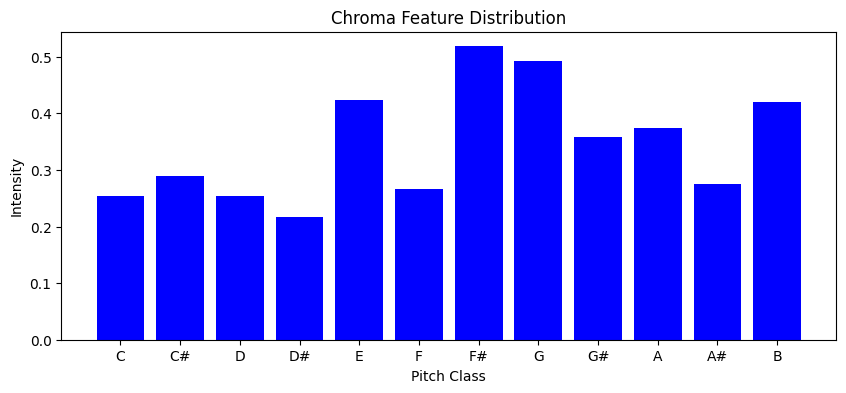

In [ ]:
@dataclass
class KeyEstimator:
    """
    Estimates the musical key of a song based on chroma feature matching.
    """

    # Krumhansl-Schmuckler Key Profiles
    major_template = np.asarray(
        [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    )
    minor_template = np.asarray(
        [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    )

    def __post_init__(self):
        # Normalize and create circulant matrices for template matching
        self.major_template = zscore(self.major_template)
        self.major_norm = scipy.linalg.norm(self.major_template)
        self.major_template = scipy.linalg.circulant(self.major_template)

        self.minor_template = zscore(self.minor_template)
        self.minor_norm = scipy.linalg.norm(self.minor_template)
        self.minor_template = scipy.linalg.circulant(self.minor_template)

    def estimate_key(self, chroma_vector: np.array, top_n: int = 3) -> List[Tuple[str, float]]:
        """
        Estimates the most likely keys from the given chroma vector.
        Returns the top `top_n` best-matching keys with confidence scores.
        """
        chroma_vector = zscore(chroma_vector)
        chroma_norm = scipy.linalg.norm(chroma_vector)

        # Compute similarity scores
        major_scores = self.major_template.T.dot(chroma_vector) / self.major_norm / chroma_norm
        minor_scores = self.minor_template.T.dot(chroma_vector) / self.minor_norm / chroma_norm

        key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

        # Create a sorted list of key matches with scores
        all_keys = []
        for i in range(12):
            all_keys.append((f"{key_names[i]} Major", major_scores[i]))
            all_keys.append((f"{key_names[i]} Minor", minor_scores[i]))

        # Sort by confidence score (highest first)
        all_keys = sorted(all_keys, key=lambda x: x[1], reverse=True)

        # Return top `top_n` possible keys
        return all_keys[:top_n]


def extract_chroma_features(song_path: str) -> np.array:
    """
    Extracts chroma features from an audio file.
    Uses Harmonic-Percussive Source Separation (HPSS) for better accuracy.
    """
    y, sr = librosa.load(song_path, sr=None)  # Load audio file

    # Apply Harmonic-Percussive Source Separation (HPSS)
    harmonic, _ = librosa.effects.hpss(y)

    # Extract chroma features using Constant-Q Transform (CQT)
    chroma = librosa.feature.chroma_cqt(y=harmonic, sr=sr)

    # Compute the mean chroma vector over the entire song
    avg_chroma = np.mean(chroma, axis=1)

    return avg_chroma

def plot_chroma(chroma_vector: np.array):
    """
    Plots the chroma feature vector for visualization.
    """
    key_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    plt.figure(figsize=(10, 4))
    plt.bar(key_labels, chroma_vector, color='blue')
    plt.xlabel("Pitch Class")
    plt.ylabel("Intensity")
    plt.title("Chroma Feature Distribution")
    plt.show()


# ====== Example Usage ======
song_path = "songs/cherry_wine.mp3"  # your file name here

print("Extracting chroma features...")
chroma_vector = extract_chroma_features(song_path)

print("Estimating key...")
estimator = KeyEstimator()
top_keys = estimator.estimate_key(chroma_vector, top_n=3)

print("Predicted Keys:")
for i, (key, score) in enumerate(top_keys):
    print(f"{i+1}. {key} (Confidence: {score:.2f})")

# Plot chroma feature distribution
plot_chroma(chroma_vector)

### Music Source Separation:

In [ ]:
def isolate_song_parts(song_filepath: str):
    """
    Separates the given song into vocals and instrumental parts using Demucs.

    Args:
        song_filepath (str): Path to the input song file.

    Raises:
        FileNotFoundError: If the song file does not exist.
        ValueError: If the file extension is not supported.
        RuntimeError: For any errors during the separation process.
    """
    try:
        # Check if the file exists
        if not os.path.isfile(song_filepath):
            raise FileNotFoundError(f"File not found: {song_filepath}")
        
        # Check if the file is an MP3 (or other supported format)
        valid_extensions = {".mp3", ".wav", ".flac", ".ogg"}
        _, ext = os.path.splitext(song_filepath)
        if ext.lower() not in valid_extensions:
            raise ValueError(f"Unsupported file format '{ext}'. Supported formats are: {', '.join(valid_extensions)}")
        
        # Run Demucs separation
        print(f"Processing file: {song_filepath}")
        demucs.separate.main(["--mp3", "-n", "htdemucs", song_filepath]) # using the htdemucs model
        print("Separation completed successfully.")

        song_name = song_filepath.replace(".mp3", "")
        return(f"separated/htdemucs/{song_name}/vocals.mp3", f"separated/htdemucs/{song_name}/other.mp3", 
               f"separated/htdemucs/{song_name}/bass.mp3", f"separated/htdemucs/{song_name}/drums.mp3")

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
    except ValueError as val_error:
        print(f"Error: {val_error}")
    except Exception as e:
        # Catch-all for unexpected errors
        print(f"An unexpected error occurred: {e}")
        raise RuntimeError("Demucs processing failed.") from e
    return (None, None)

song_path = "songs/cherry_wine.mp3" # your file name here
separated_track_paths = isolate_song_parts(song_path)
print("The separated tracks are located at: ", separated_track_paths)

Processing file: songs/cherry_wine.mp3
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in C:\Users\Jimmy\Desktop\Uni\Fourth Year Uni\SPRING 2025\CSC 475\Repo\Mashify\separated\htdemucs
Separating track songs\cherry_wine.mp3


100%|████████████████████████████████████████████████████████████████████████| 175.5/175.5 [01:02<00:00,  2.82seconds/s]


Separation completed successfully.
The separated tracks are located at:  ('separated/htdemucs/songs/cherry_wine/vocals.mp3', 'separated/htdemucs/songs/cherry_wine/other.mp3', 'separated/htdemucs/songs/cherry_wine/bass.mp3', 'separated/htdemucs/songs/cherry_wine/drums.mp3')


### Music Structure Analysis:

## Mashing Step:

Includes generating mashability score and mashup generation

### Mashability Score

### Mashup Generation

## Evaluation Step: